_Lambda School Data Science - Model Validation_


# Feature Selection

Objectives:
* Feature importance
* Feature selection 

## Yesterday we saw that...

## Less isn't always more (but sometimes it is)

## More isn't always better (but sometimes it is)


![Image of Terry Crews](https://media.giphy.com/media/b8kHKZq3YFfnq/giphy.gif)

Saavas, Ando [Feature Selection (4 parts)](https://blog.datadive.net/selecting-good-features-part-i-univariate-selection/)

>There are in general two reasons why feature selection is used:
1. Reducing the number of features, to reduce overfitting and improve the generalization of models.
2. To gain a better understanding of the features and their relationship to the response variables.

>These two goals are often at odds with each other and thus require different approaches: depending on the data at hand a feature selection method that is good for goal (1) isn’t necessarily good for goal (2) and vice versa. What seems to happen often though is that people use their favourite method (or whatever is most conveniently accessible from their tool of choice) indiscriminately, especially methods more suitable for (1) for achieving (2).

While they are not always mutually exclusive, here's a little bit about what's going on with these two goals

### Goal 1: Reducing Features, Reducing Overfitting, Improving Generalization of Models

This is when you're actually trying to engineer a packaged, machine learning pipeline that is streamlined and highly generalizable to novel data as more is collected, and you don't really care "how" it works as long as it does work. 

Approaches that are good at this tend to fail at Goal 2 because they handle multicollinearity by (sometime randomly) choosing/indicating just one of a group of strongly correlated features. This is good to reduce redundancy, but bad if you want to interpret the data.

### Goal 2: Gaining a Better Understanding of the Features and their Relationships

This is when you want a good, interpretable model or you're doing data science more for analysis than engineering. Company asks you "How do we increase X?" and you can tell them all the factors that correlate to it and their predictive power.

Approaches that are good at this tend to fail at Goal 1 because, well, they *don't* handle the multicollinearity problem. If three features are all strongly correlated to each other as well as the output, they will all have high scores. But including all three features in a model is redundant.

### Each part in Saavas's Blog series describes an increasingly complex (and computationally costly) set of methods for feature selection and interpretation.

The ultimate comparison is completed using an adaptation of a dataset called Friedman's 1 regression dataset from Friedman, Jerome H.'s '[Multivariate Adaptive Regression Splines](http://www.stat.ucla.edu/~cocteau/stat204/readings/mars.pdf).
>The data is generated according to formula $y=10sin(πX_1X_2)+20(X_3–0.5)^2+10X_4+5X_5+ϵ$, where the $X_1$ to $X_5$ are drawn from uniform distribution and ϵ is the standard normal deviate N(0,1). Additionally, the original dataset had five noise variables $X_6,…,X_{10}$, independent of the response variable. We will increase the number of variables further and add four variables $X_{11},…,X_{14}$ each of which are very strongly correlated with $X_1,…,X_4$, respectively, generated by $f(x)=x+N(0,0.01)$. This yields a correlation coefficient of more than 0.999 between the variables. This will illustrate how different feature ranking methods deal with correlations in the data.

**Okay, that's a lot--here's what you need to know:**
1.   $X_1$ and $X_2$ have the same non-linear relationship to $Y$ -- though together they do have a not-quite-linear relationship to $Y$ (with sinusoidal noise--but the range of the values doesn't let it get negative)
2.   $X_3$ has a quadratic relationship with $Y$
3.   $X_4$ and $X_5$ have linear relationships to $Y$, with $X_4$ being weighted twice as heavily as $X_5$
4.   $X_6$ through $X_{10}$ are random and have NO relationship to $Y$
5.   $X_{11}$ through $X_{14}$ correlate strongly to $X_1$ through $X_4$ respectively (and thus have the same respective relationships with $Y$)


This will help us see the difference between the models in selecting features and interpreting features
* how well they deal with multicollinearity (#5)
* how well they identify noise (#4)
* how well they identify different kinds of relationships
* how well they identify/interpret predictive power of individual variables.

In [1]:
# import
import numpy as np

# Create the dataset
# from https://blog.datadive.net/selecting-good-features-part-iv-stability-selection-rfe-and-everything-side-by-side/

np.random.seed(42)

size = 1500 # I increased the size from what's given in the link
Xs = np.random.uniform(0, 1, (size, 14)) 
# Changed variable name to Xs to use X later
 
#"Friedamn #1” regression problem
Y = (10 * np.sin(np.pi*Xs[:,0]*Xs[:,1]) + 20*(Xs[:,2] - .5)**2 +
     10*Xs[:,3] + 5*Xs[:,4] + np.random.normal(0,1))
#Add 4 additional correlated variables (correlated with X1-X4)
Xs[:,10:] = Xs[:,:4] + np.random.normal(0, .025, (size,4))
 
names = ["X%s" % i for i in range(1,15)]

In [2]:
# Putting it into pandas--because... I like pandas. And usually you'll be
# working with dataframes not arrays (you'll care what the column titles are)
import pandas as pd

friedmanX = pd.DataFrame(data=Xs, columns=names)
friedmanY = pd.Series(data=Y, name='Y')

friedman = friedmanX.join(friedmanY)

friedman.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,Y
0,0.374540,0.950714,0.731994,0.598658,0.156019,0.155995,0.058084,0.866176,0.601115,0.708073,0.413325,0.956360,0.698205,0.568729,16.730915
1,0.181825,0.183405,0.304242,0.524756,0.431945,0.291229,0.611853,0.139494,0.292145,0.366362,0.223650,0.167876,0.280668,0.561691,9.112092
2,0.592415,0.046450,0.607545,0.170524,0.065052,0.948886,0.965632,0.808397,0.304614,0.097672,0.617692,0.078302,0.583794,0.132396,3.017894
3,0.034389,0.909320,0.258780,0.662522,0.311711,0.520068,0.546710,0.184854,0.969585,0.775133,0.037718,0.917699,0.267895,0.699477,10.220976
4,0.088493,0.195983,0.045227,0.325330,0.388677,0.271349,0.828738,0.356753,0.280935,0.542696,0.045148,0.217475,0.017812,0.346724,9.770285


We want to be able to look at classification problems too, so let's bin the Y values to create a categorical feature from the Y values. It should have *roughly* similar relationships to the X features as Y does.

In [3]:
# First, let's take a look at what Y looks like
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(friedmanY);

That's pretty normal, let's make two binary categories--one balanced, one unbalanced, to see the difference.
* balanced binary variable will be split evenly in half
* unbalanced binary variable will indicate whether $Y <5$.

In [4]:
friedman['Y_bal'] = friedman['Y'].apply(lambda y: 1 if (y < friedman.Y.median()) else 0)
friedman['Y_un'] = friedman['Y'].apply(lambda y: 1 if (y < 5) else 0)

print(friedman.Y_bal.value_counts(), '\n\n', friedman.Y_un.value_counts())

1    750
0    750
Name: Y_bal, dtype: int64 

 0    1461
1      39
Name: Y_un, dtype: int64


In [5]:
friedman.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,Y,Y_bal,Y_un
0,0.374540,0.950714,0.731994,0.598658,0.156019,0.155995,0.058084,0.866176,0.601115,0.708073,0.413325,0.956360,0.698205,0.568729,16.730915,0,0
1,0.181825,0.183405,0.304242,0.524756,0.431945,0.291229,0.611853,0.139494,0.292145,0.366362,0.223650,0.167876,0.280668,0.561691,9.112092,1,0
2,0.592415,0.046450,0.607545,0.170524,0.065052,0.948886,0.965632,0.808397,0.304614,0.097672,0.617692,0.078302,0.583794,0.132396,3.017894,1,1
3,0.034389,0.909320,0.258780,0.662522,0.311711,0.520068,0.546710,0.184854,0.969585,0.775133,0.037718,0.917699,0.267895,0.699477,10.220976,1,0
4,0.088493,0.195983,0.045227,0.325330,0.388677,0.271349,0.828738,0.356753,0.280935,0.542696,0.045148,0.217475,0.017812,0.346724,9.770285,1,0


In [6]:
# Finally, let's put it all into our usual X and y's
# (I already have the X dataframe as friedmanX, but I'm working backward to
# follow a usual flow)

X = friedman.drop(columns=['Y', 'Y_bal', 'Y_un'])

y = friedman.Y

y_bal = friedman.Y_bal

y_un = friedman.Y_un

#### Alright! Let's get to it! Remember, with each part, we are increasing complexity of the analysis and thereby increasing the computational costs and runtime.

So even before univariate selection--which compares each feature to the output feature one by one--there is a [VarianceThreshold](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html#sklearn.feature_selection.VarianceThreshold) object in sklearn.feature_selection. It defaults to getting rid of any features that are the same across all samples. Great for cleaning data in that respect. 

The `threshold` parameter defaults to `0` to show the above behavior. if you change it, make sure you have good reason. Use with caution.

## Part 1: univariate selection
* Best for goal 2 - getting "a better understanding of the data, its structure and characteristics"
* unable to remove redundancy (for example selecting only the best feature among a subset of strongly correlated features)
* Super fast - can be used for baseline models or just after baseline

[sci-kit's univariariate feature selection objects and techniques](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection)

#### Y (continuous output)

options (they do what they sound like they do)
* SelectKBest
* SelectPercentile

both take the same parameter options for `score_func`
* `f_regression`: scores by correlation coefficient, f value, p value--basically automates what you can do by looking at a correlation matrix except without the ability to recognize collinearity
* `mutual_info_regression`: can capture non-linear correlations, but doesn't handle noise well

Let's take a look at mutual information (MI)

In [7]:
import sklearn.feature_selection as fe

MIR = fe.SelectKBest(fe.mutual_info_regression, k='all').fit(X, y)

MIR_scores = pd.Series(data=MIR.scores_, name='MI_Reg_Scores', index=names)

MIR_scores

X1     0.117499
X2     0.155141
X3     0.064104
X4     0.239914
X5     0.059098
X6     0.006906
X7     0.000000
X8     0.000000
X9     0.000000
X10    0.000000
X11    0.069175
X12    0.113326
X13    0.036673
X14    0.220115
Name: MI_Reg_Scores, dtype: float64

#### Y_bal (balanced binary output)

options
* SelectKBest
* SelectPercentile

these options will cut out features with error rates above a certain tolerance level, define in parameter -`alpha`
* SelectFpr (false positive rate--false positives predicted/total negatives in dataset)
* SelectFdr (false discovery rate--false positives predicted/total positives predicted)
* ~~SelectFwe (family-wise error--for multinomial classification tasks)~~

all have the same optons for parameter `score_func`
* `chi2`
* `f_classif`
* `mutual_info_classif`

In [8]:
MIC_b = fe.SelectFpr(fe.mutual_info_classif).fit(X, y_bal)

MIC_b_scores = pd.Series(data=MIC_b.scores_, 
                              name='MIC_Bal_Scores', index=names)

MIC_b_scores

X1     0.061386
X2     0.111060
X3     0.006320
X4     0.113995
X5     0.000000
X6     0.000000
X7     0.000000
X8     0.000000
X9     0.000000
X10    0.018296
X11    0.063916
X12    0.091263
X13    0.028924
X14    0.109699
Name: MIC_Bal_Scores, dtype: float64

#### Y_un (unbalanced binary output)

In [9]:
MIC_u = fe.SelectFpr(fe.mutual_info_classif).fit(X, y_un)

MIC_u_scores = pd.Series(data=MIC_u.scores_, 
                              name='MIC_Unbal_Scores', index=names)

MIC_u_scores

X1     0.007352
X2     0.011942
X3     0.010933
X4     0.042207
X5     0.015932
X6     0.000000
X7     0.000000
X8     0.006586
X9     0.000000
X10    0.000000
X11    0.004096
X12    0.011106
X13    0.006392
X14    0.033513
Name: MIC_Unbal_Scores, dtype: float64

## Part 2: linear models and regularization
* L1 Regularization (Lasso for regression) is best for goal 1: "produces sparse solutions and as such is very useful selecting a strong subset of features for improving model performance" (forces coefficients to zero, telling you which you could remove--but doesn't handle multicollinearity)
* L2 Regularization (Ridge for regression) is best for goal 2: "can be used for data interpretation due to its stability and the fact that useful features tend to have non-zero coefficients
* Also fast

[sci-kit's L1 feature selection](https://scikit-learn.org/stable/modules/feature_selection.html#l1-based-feature-selection) (can easily be switched to L2 using the parameter `penalty='l2'` for categorical targets or using `Ridge` instead of Lasso for continuous targets)

We won't do this here, because
1.   You know regression
2.   The same principles apply as shown in Part 3 below with `SelectFromModel`
3.   There's way cooler stuff coming up

## Part 3: random forests
* Best for goal 1, not 2 because:
 * strong features can end up with low scores 
 * biased towards variables with many categories
* "require very little feature engineering and parameter tuning"
* Takes a little more time depending on your dataset - but a popular technique

[sci-kit's implementation of tree-based feature selection](https://scikit-learn.org/stable/modules/feature_selection.html#tree-based-feature-selection)

#### Y

In [10]:
from sklearn.ensemble import RandomForestRegressor as RFR

# Fitting a random forest regression
rfr = RFR().fit(X, y)

# Creating scores from feature_importances_ ranking (some randomness here)
rfr_scores = pd.Series(data=rfr.feature_importances_, name='RFR', index=names)

rfr_scores

/home/seek/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


X1     0.171971
X2     0.080160
X3     0.031443
X4     0.277327
X5     0.089315
X6     0.006989
X7     0.007058
X8     0.007323
X9     0.007486
X10    0.007776
X11    0.045425
X12    0.133982
X13    0.024321
X14    0.109423
Name: RFR, dtype: float64

#### Y_bal

In [11]:
from sklearn.ensemble import RandomForestClassifier as RFC

# Fitting a Random Forest Classifier
rfc_b = RFC().fit(X, y_bal)

# Creating scores from feature_importances_ ranking (some randomness here)
rfc_b_scores = pd.Series(data=rfc_b.feature_importances_, name='RFC_bal', 
                           index=names)

rfc_b_scores

/home/seek/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


X1     0.119943
X2     0.115253
X3     0.039748
X4     0.114719
X5     0.071332
X6     0.027339
X7     0.024874
X8     0.026811
X9     0.028619
X10    0.018861
X11    0.116147
X12    0.103445
X13    0.042709
X14    0.150199
Name: RFC_bal, dtype: float64

#### Y_un

In [12]:
# Fitting a Random Forest Classifier
rfc_u = RFC().fit(X, y_un)

# Creating scores from feature_importances_ ranking (some randomness here)
rfc_u_scores = pd.Series(data=rfc_u.feature_importances_, 
                             name='RFC_unbal', index=names)

rfc_u_scores

/home/seek/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


X1     0.075621
X2     0.130585
X3     0.030374
X4     0.175625
X5     0.064946
X6     0.078695
X7     0.024836
X8     0.029368
X9     0.031935
X10    0.030780
X11    0.059017
X12    0.104890
X13    0.015534
X14    0.147796
Name: RFC_unbal, dtype: float64

### SelectFromModel 
is a meta-transformer that can be used along with any estimator that has a `coef_` or `feature_importances_` attribute after fitting. The features are considered unimportant and removed, if the corresponding `coef_` or `feature_importances_` values are below the provided `threshold` parameter. Apart from specifying the `threshold` numerically, there are built-in heuristics for finding a `threshold` using a string argument. Available heuristics are `'mean'`, `'median'` and float multiples of these like `'0.1*mean'`.

In [13]:
# Random forest regression transformation of X (elimination of least important
# features)
rfr_transform = fe.SelectFromModel(rfr, prefit=True)

X_rfr = rfr_transform.transform(X)


# Random forest classifier transformation of X_bal (elimination of least important
# features)
rfc_b_transform = fe.SelectFromModel(rfc_b, prefit=True)

X_rfc_b = rfc_b_transform.transform(X)


# Random forest classifier transformation of X_un (elimination of least important
# features)
rfc_u_transform = fe.SelectFromModel(rfc_u, prefit=True)

X_rfc_u = rfc_u_transform.transform(X)

In [14]:
RF_comparisons = pd.DataFrame(data=np.array([rfr_transform.get_support(),
                                    rfc_b_transform.get_support(),
                                    rfc_u_transform.get_support()]).T,
                              columns=['RF_Regressor', 'RF_balanced_classifier',
                                     'RF_unbalanced_classifier'],
                              index=names)

RF_comparisons

,RF_Regressor,RF_balanced_classifier,RF_unbalanced_classifier
X1,True,True,True
X2,True,True,True
X3,False,False,False
X4,True,True,True
X5,True,False,False
X6,False,False,True
X7,False,False,False
X8,False,False,False
X9,False,False,False
X10,False,False,False


## Part 4: stability selection, RFE, and everything side by side
* These methods take longer since they are *wrapper methods* and build multiple ML models before giving results. "They both build on top of other (model based) selection methods such as regression or SVM, building models on different subsets of data and extracting the ranking from the aggregates."
* Stability selection is good for both goal 1 and 2: "among the top performing methods for many different datasets and settings"
 * For categorical targets
   * ~~[RandomizedLogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RandomizedLogisticRegression.html)~~ (Deprecated) use [RandomizedLogisticRegression](https://thuijskens.github.io/stability-selection/docs/randomized_lasso.html#stability_selection.randomized_lasso.RandomizedLogisticRegression)
  
   * [ExtraTreesClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier)
 
 * For continuous targets
   * ~~[RandomizedLasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RandomizedLasso.html)~~ (Deprecated) use [RandomizedLasso](https://thuijskens.github.io/stability-selection/docs/randomized_lasso.html#stability_selection.randomized_lasso.RandomizedLogisticRegression) 
   * [ExtraTreesRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html#sklearn.ensemble.ExtraTreesRegressor)
   
    Welcome to open-source, folks! [Here](https://github.com/scikit-learn/scikit-learn/issues/8995) is the original discussion to deprecate `RandomizedLogisticRegression` and `RandomizedLasso`. [Here](https://github.com/scikit-learn/scikit-learn/issues/9657) is a failed attempt to resurrect it. It looks like it'll be gone for good soon. So we shouldn't get dependent on it.

    The alternatives from the deprecated scikit objects come from an official scikit-learn-contrib module called [stability_selection](https://github.com/scikit-learn-contrib/stability-selection). They also have a `StabilitySelection` object that acts similarly scikit's `SelectFromModel`.

* recursive feature elimination (RFE) is best for goal 1
 * [sci-kit's RFE and RFECV (RFE with built-in cross-validation)](https://scikit-learn.org/stable/modules/feature_selection.html#recursive-feature-elimination)

In [15]:
!pip install git+https://github.com/scikit-learn-contrib/stability-selection.git

  Cloning https://github.com/scikit-learn-contrib/stability-selection.git to /tmp/pip-req-build-axvzrzpv
  Stored in directory: /tmp/pip-ephem-wheel-cache-woii323n/wheels/58/be/39/79880712b91ffa56e341ff10586a1956527813437ddd759473
Successfully built stability-selection


Okay, I tried this package... it seems to have some problems... hopefully a good implementation of stability selection for Lasso and Logistic Regression will be created soon! In the meantime, scikit's RandomLasso and RandomLogisticRegression have not been removed, so you can fiddle some! Just alter the commented out code!
* import from scikit instead of stability-selection
* use scikit's `SelectFromModel` as shown above!

Ta Da!

#### Y

In [16]:
'''from stability_selection import (RandomizedLogisticRegression,
                                 RandomizedLasso, StabilitySelection,
                                 plot_stability_path)

# Stability selection using randomized lasso method
rl = RandomizedLasso(max_iter=2000)
rl_selector = StabilitySelection(base_estimator=rl, lambda_name='alpha',
                                 n_jobs=2)
rl_selector.fit(X, y);
'''

"from stability_selection import (RandomizedLogisticRegression,\n                                 RandomizedLasso, StabilitySelection,\n                                 plot_stability_path)\n\n# Stability selection using randomized lasso method\nrl = RandomizedLasso(max_iter=2000)\nrl_selector = StabilitySelection(base_estimator=rl, lambda_name='alpha',\n                                 n_jobs=2)\nrl_selector.fit(X, y);\n"

In [17]:
from sklearn.ensemble import ExtraTreesRegressor as ETR

# Stability selection using randomized decision trees
etr = ETR(n_estimators=50).fit(X, y)

# Creating scores from feature_importances_ ranking (some randomness here)
etr_scores = pd.Series(data=etr.feature_importances_, 
                             name='ETR', index=names)

etr_scores

X1     0.124593
X2     0.116771
X3     0.030910
X4     0.204025
X5     0.086907
X6     0.008103
X7     0.008218
X8     0.008241
X9     0.007985
X10    0.007440
X11    0.106018
X12    0.104079
X13    0.029207
X14    0.157503
Name: ETR, dtype: float64

In [18]:
from sklearn.linear_model import LinearRegression

# Recursive feature elimination with cross validaiton using linear regression 
# as the model
lr = LinearRegression()
# rank all features, i.e continue the elimination until the last one
rfe = fe.RFECV(lr)
rfe.fit(X, y)

rfe_score = pd.Series(data=(-1*rfe.ranking_), name='RFE', index=names)

rfe_score

/home/seek/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


X1    -1
X2    -1
X3    -1
X4    -1
X5    -1
X6    -8
X7    -5
X8    -7
X9    -6
X10   -9
X11   -2
X12   -4
X13   -1
X14   -3
Name: RFE, dtype: int64

#### Y_bal

In [19]:
# stability selection using randomized logistic regression
'''rlr_b = RandomizedLogisticRegression()
rlr_b_selector = StabilitySelection(base_estimator=rlr_b, lambda_name='C',
                                 n_jobs=2)
rlr_b_selector.fit(X, y_bal);'''

"rlr_b = RandomizedLogisticRegression()\nrlr_b_selector = StabilitySelection(base_estimator=rlr_b, lambda_name='C',\n                                 n_jobs=2)\nrlr_b_selector.fit(X, y_bal);"

In [20]:
from sklearn.ensemble import ExtraTreesClassifier as ETC

# Stability selection using randomized decision trees
etc_b = ETC(n_estimators=50).fit(X, y_bal)

# Creating scores from feature_importances_ ranking (some randomness here)
etc_b_scores = pd.Series(data=etc_b.feature_importances_, 
                             name='ETC_bal', index=names)

etc_b_scores

X1     0.105576
X2     0.113267
X3     0.044241
X4     0.133987
X5     0.079805
X6     0.028492
X7     0.026542
X8     0.029527
X9     0.030618
X10    0.026719
X11    0.110347
X12    0.096993
X13    0.044999
X14    0.128890
Name: ETC_bal, dtype: float64

In [21]:
from sklearn.linear_model import LogisticRegression

# Recursive feature elimination with cross validaiton using logistic regression 
# as the model
logr_b = LogisticRegression(solver='lbfgs')
# rank all features, i.e continue the elimination until the last one
rfe_b = fe.RFECV(logr_b)
rfe_b.fit(X, y_bal)

rfe_b_score = pd.Series(data=(-1*rfe_b.ranking_), name='RFE_bal', index=names)

rfe_b_score

/home/seek/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


X1    -1
X2    -1
X3    -1
X4    -1
X5    -1
X6    -4
X7    -1
X8    -2
X9    -3
X10   -1
X11   -1
X12   -1
X13   -5
X14   -1
Name: RFE_bal, dtype: int64

#### Y_un

In [22]:
# stability selection uisng randomized logistic regression
'''rlr_u = RandomizedLogisticRegression(max_iter=2000)
rlr_u_selector = StabilitySelection(base_estimator=rlr_u, lambda_name='C')

rlr_u_selector.fit(X, y_un);'''

"rlr_u = RandomizedLogisticRegression(max_iter=2000)\nrlr_u_selector = StabilitySelection(base_estimator=rlr_u, lambda_name='C')\n\nrlr_u_selector.fit(X, y_un);"

In [23]:
# Stability selection using randomized decision trees
etc_u = ETC(n_estimators=50).fit(X, y_un)

# Creating scores from feature_importances_ ranking (some randomness here)
etc_u_scores = pd.Series(data=etc_u.feature_importances_, 
                             name='ETC_unbal', index=names)

etc_u_scores

X1     0.080087
X2     0.091999
X3     0.056712
X4     0.122631
X5     0.082176
X6     0.039102
X7     0.046938
X8     0.042750
X9     0.052450
X10    0.058599
X11    0.080919
X12    0.091330
X13    0.046816
X14    0.107490
Name: ETC_unbal, dtype: float64

In [24]:
# Recursive feature elimination with cross validaiton using logistic regression 
# as the model
logr_u = LogisticRegression(solver='lbfgs')
# rank all features, i.e continue the elimination until the last one
rfe_u = fe.RFECV(logr_u)
rfe_u.fit(X, y_un)

rfe_u_score = pd.Series(data=(-1*rfe_u.ranking_), name='RFE_unbal', index=names)

rfe_u_score

/home/seek/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


X1    -1
X2    -1
X3    -6
X4    -1
X5    -1
X6    -4
X7    -5
X8    -1
X9    -3
X10   -1
X11   -1
X12   -1
X13   -2
X14   -1
Name: RFE_unbal, dtype: int64

In [25]:
'''RL_comparisons = pd.DataFrame(data=np.array([rl_selector.get_support(),
                                    rlr_b_selector.get_support(),
                                    rlr_u_selector.get_support()]).T,
                              columns=['RandomLasso', 'RandomLog_bal',
                                     'RandomLog_unbal'],
                              index=names)

RL_comparisons'''

"RL_comparisons = pd.DataFrame(data=np.array([rl_selector.get_support(),\n                                    rlr_b_selector.get_support(),\n                                    rlr_u_selector.get_support()]).T,\n                              columns=['RandomLasso', 'RandomLog_bal',\n                                     'RandomLog_unbal'],\n                              index=names)\n\nRL_comparisons"

In [26]:
comparisons = pd.concat([MIR_scores, MIC_b_scores, MIC_u_scores, rfr_scores,
                         rfc_b_scores, rfc_u_scores, etr_scores, etc_b_scores,
                         etc_u_scores, rfe_score, rfe_b_score, rfe_u_score], 
                        axis=1)

comparisons

,MI_Reg_Scores,MIC_Bal_Scores,MIC_Unbal_Scores,RFR,RFC_bal,RFC_unbal,ETR,ETC_bal,ETC_unbal,RFE,RFE_bal,RFE_unbal
X1,0.117499,0.061386,0.007352,0.171971,0.119943,0.075621,0.124593,0.105576,0.080087,-1,-1,-1
X2,0.155141,0.111060,0.011942,0.080160,0.115253,0.130585,0.116771,0.113267,0.091999,-1,-1,-1
X3,0.064104,0.006320,0.010933,0.031443,0.039748,0.030374,0.030910,0.044241,0.056712,-1,-1,-6
X4,0.239914,0.113995,0.042207,0.277327,0.114719,0.175625,0.204025,0.133987,0.122631,-1,-1,-1
X5,0.059098,0.000000,0.015932,0.089315,0.071332,0.064946,0.086907,0.079805,0.082176,-1,-1,-1
X6,0.006906,0.000000,0.000000,0.006989,0.027339,0.078695,0.008103,0.028492,0.039102,-8,-4,-4
X7,0.000000,0.000000,0.000000,0.007058,0.024874,0.024836,0.008218,0.026542,0.046938,-5,-1,-5
X8,0.000000,0.000000,0.006586,0.007323,0.026811,0.029368,0.008241,0.029527,0.042750,-7,-2,-1
X9,0.000000,0.000000,0.000000,0.007486,0.028619,0.031935,0.007985,0.030618,0.052450,-6,-3,-3
X10,0.000000,0.018296,0.000000,0.007776,0.018861,0.030780,0.007440,0.026719,0.058599,-9,-1,-1


In [27]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(comparisons)
scaled_comparisons = pd.DataFrame(scaled_df, columns=comparisons.columns,
                                 index=names)

scaled_comparisons

/home/seek/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,MI_Reg_Scores,MIC_Bal_Scores,MIC_Unbal_Scores,RFR,RFC_bal,RFC_unbal,ETR,ETC_bal,ETC_unbal,RFE,RFE_bal,RFE_unbal
X1,0.489754,0.538498,0.174183,0.610281,0.769634,0.375329,0.595941,0.735575,0.490660,1.000,1.00,1.0
X2,0.646649,0.974248,0.282945,0.270663,0.733926,0.718660,0.556153,0.807153,0.633275,1.000,1.00,1.0
X3,0.267194,0.055444,0.259036,0.090456,0.159033,0.092698,0.119387,0.164721,0.210819,1.000,1.00,0.0
X4,1.000000,1.000000,1.000000,1.000000,0.729859,1.000000,1.000000,1.000000,1.000000,1.000,1.00,1.0
X5,0.246328,0.000000,0.377462,0.304530,0.399514,0.308646,0.404238,0.495718,0.515675,1.000,1.00,1.0
X6,0.028786,0.000000,0.000000,0.000000,0.064555,0.394528,0.003373,0.018143,0.000000,0.125,0.25,0.4
X7,0.000000,0.000000,0.000000,0.000256,0.045787,0.058103,0.003961,0.000000,0.093808,0.500,1.00,0.2
X8,0.000000,0.000000,0.156048,0.001235,0.060536,0.086412,0.004077,0.027778,0.043674,0.250,0.75,1.0
X9,0.000000,0.000000,0.000000,0.001839,0.074299,0.102447,0.002772,0.037931,0.159792,0.375,0.50,0.6
X10,0.000000,0.160500,0.000000,0.002909,0.000000,0.095233,0.000000,0.001641,0.233413,0.000,1.00,1.0


### What do you notice from the diagram below?

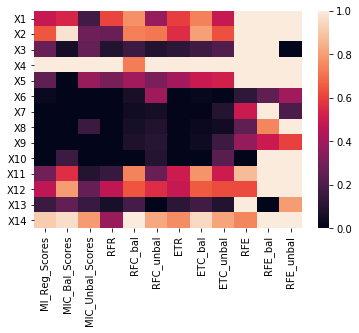

In [28]:
sns.heatmap(scaled_comparisons);

Head, Tim [Cross Validation Gone Wrong](https://betatim.github.io/posts/cross-validation-gone-wrong/)

>Choosing your input features is just one of the many choices you have to make when building your machine-learning application. Remember to make all decisions during the cross validation, otherwise you are in for a rude awakening when your model is confronted with unseen data for the first time.

![Image of Machine Learning](https://www.capgemini.com/wp-content/uploads/2017/07/machinelearning_v2.png)

\[Image by Angarita, Natalia for [Capgemini](https://www.capgemini.com/2016/05/machine-learning-has-transformed-many-aspects-of-our-everyday-life/)\]

**I don't fully support this diagram for a few reasons.**

* I would replace "Feature Engineering" with "Data Cleaning"
* Feature engineering can be done alongside either data cleaning or training your model--it can be done before *or* after splitting your data. (But it will need to be part of the final pipeline.)
* Any feature standardization happens **after** the split
* And you can use cross validation instead of an independent validation set

However **feature selection (Goal 1) is part of choosing and training a model and should happen *after* splitting**. Feature selection belongs safely **inside the dotted line**.

"But doesn't it make sense to make your decisions based on all the information?"

NO! Mr. Head has a point!

## The number of features you end up using *is* a hyperparameter. Don't cross the dotted line while hyperparameter tuning!!! Work on goal 1 AFTER splitting.

I know you want to see how your model is performing... "just real quick"... but don't do it!

...

Don't!

*(Kaggle does the initial train-test split for you. It doesn't even let you **see** the target values for the test data. How you like dem apples?)*

![](https://media.giphy.com/media/3o7TKGoQ8721rQQ0es/giphy.gif)

What you **can** do is create multiple "final" models by hyperparameter tuning different types of models (all inside the dotted line!), then use the final hold-out test to see which does best.

**All this is said with the caveat that you have a large enough dataset to support three way validation or a test set plus cross-validation**

## On the flip side, feature *interpretation* (Goal 2) can be done with all the data, before splitting, since you are looking to get a full understanding underlying the relationships in the dataset.